# **PART 5:** Cluster annotation & visualization
In this tutorial we will combine all the results from TCRex and ClusTCR and attempt to interpret them.

In [1]:
import os
# Set the working directory to the repository directory
os.chdir("/home/sebastiaan/PhD/Repositories/book_chapter/")

In addition to the pandas and numpy libraries, we will import the custom function `merge_results` from the "./src" folder in this repository. This function will perform the necessary steps to merge the original data files (which we will need to remap the J genes), the clustering results and the TCRex results. In this tutorial we will illustrate a basic visualization strategy, which will require the networkx library, as well as the custom `create_edgelist_vgene` function.

In [2]:
import pandas as pd
import numpy as np
import networkx as nx

from src.tools import merge_results, create_edgelist_vgene

We start by merging the results for P1 at day 0.

In [4]:
# TCRex results
tcrex = pd.read_csv("./results/tcrex/P1_0_tcrex.tsv", sep = "\t")
# ClusTCR results
clust = pd.read_csv("./results/clustcr/P1_0_clusters.tsv", sep = "\t")
# Original data
rawdata = pd.read_csv("./data/examples/P1_0.tsv", sep = "\t")

merged_0 = merge_results(
    original = rawdata,
    clusters = clust,
    predictions = tcrex
    )

# Drop TCRs that do not belong to any cluster
merged_0 = merged_0.dropna(subset = ["cluster"])

# Select the columns we want to keep
keep = ["duplicate_count",
        "frequency",
        "junction_aa", 
        "v_call", 
        "j_call", 
        "cluster",
        "epitope",
        "pathology",
        "score",
        "bpr"]
merged_0 = merged_0[keep]
# Save results to file
merged_0.to_csv("./results/merged/P1_0_clusters_tcrex.tsv", sep = "\t", index = False)

In [5]:
merged_0.head()

,duplicate_count,frequency,junction_aa,v_call,j_call,cluster,epitope,pathology,score,bpr
0,4444.0,0.001663,CASSEREANEQFF,TRBV6-4,TRBJ2-1,26.0,NaN,NaN,NaN,NaN
1,2356.0,0.000881,CASSDRSGGADEQFF,TRBV6-4,TRBJ2-1,1003.0,NaN,NaN,NaN,NaN
2,789.0,0.000295,CASSYGAGANVLTF,TRBV6-5,TRBJ2-6,823.0,NaN,NaN,NaN,NaN
3,737.0,0.000276,CASSEDGNTEAFF,TRBV6-4,TRBJ1-1,43.0,NaN,NaN,NaN,NaN
4,730.0,0.000273,CASSEATGGANVLTF,TRBV6-4,TRBJ2-6,1069.0,NaN,NaN,NaN,NaN


We do the same for P1 at day 15 post YFV vaccination.

In [6]:
# TCRex results
tcrex = pd.read_csv("./results/tcrex/P1_15_tcrex.tsv", sep = "\t")
# ClusTCR results
clust = pd.read_csv("./results/clustcr/P1_15_clusters.tsv", sep = "\t")
# Original data
rawdata = pd.read_csv("./data/examples/P1_15.tsv", sep = "\t")

merged_15 = merge_results(
    original = rawdata,
    clusters = clust,
    predictions = tcrex
    )

merged_15 = merged_15.dropna(subset = ["cluster"])

keep = ["duplicate_count",
        "frequency",
        "junction_aa", 
        "v_call", 
        "j_call", 
        "cluster",
        "epitope",
        "pathology",
        "score",
        "bpr"]

merged_15 = merged_15[keep]
merged_15.to_csv("./results/merged/P1_15_clusters_tcrex.tsv", sep = "\t", index = False)

In [7]:
merged_15.head()

,duplicate_count,frequency,junction_aa,v_call,j_call,cluster,epitope,pathology,score,bpr
0,1480.0,0.000814,CASSDRSGGADEQFF,TRBV6-4,TRBJ2-1,197.0,NaN,NaN,NaN,NaN
1,857.0,0.000471,CASSEDPRLQRDEQFF,TRBV6-1,TRBJ2-1,69.0,NaN,NaN,NaN,NaN
2,687.0,0.000378,CASSDSPTGAYGYTF,TRBV6-1,TRBJ1-2,423.0,NaN,NaN,NaN,NaN
3,558.0,0.000307,CASSERENTEAFF,TRBV6-4,TRBJ1-1,628.0,NaN,NaN,NaN,NaN
4,3.0,0.000002,CASSERENTEAFF,TRBV6-1,TRBJ1-1,628.0,NaN,NaN,NaN,NaN


Now we will select only those cluster that contain at least one TCR with at least one epitope annotation. Next, we will count the number of epitopes within each cluster and sort the data according to the number of (epitope-)annotated TCRs in the cluster (high -> low).

In [11]:
clusters_with_hits = set(merged_0.dropna(subset = "epitope").cluster)
subset = merged_0[merged_0.cluster.isin(clusters_with_hits)]

epi_count = subset.groupby("cluster").count().epitope.sort_index()
cluster_size = merged_0.cluster.value_counts()[clusters_with_hits].sort_index()

res = pd.concat([epi_count, cluster_size], axis = 1)
res = res.rename(columns = {
    'epitope' : 'epitope_specific_tcrs',
    'cluster' : 'cluster_size'
    })
res.sort_values(by = "epitope_specific_tcrs", ascending = False).head(10)

/tmp/ipykernel_33359/3768177567.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_size = merged_0.cluster.value_counts()[clusters_with_hits].sort_index()


,epitope_specific_tcrs,cluster_size
1861.0,508,528
1850.0,504,598
1852.0,403,554
2058.0,326,364
2063.0,286,365
2481.0,195,266
1859.0,169,191
1854.0,155,212
2064.0,154,192
1858.0,133,232


We can perform the same analysis, but this time only looking at a particular pathology of interest. In this case, we are interested in the number of YFV-specific clusters. First, we will perform this for the day 0 sample.

In [94]:
# Identify clusters with hits
clusters_with_hits = set(merged_0[merged_0.pathology=='YellowFeverVirus'].cluster)
subset = merged_0[merged_0.cluster.isin(clusters_with_hits)]

# Calculate their cluster size
cluster_size = merged_0.cluster.value_counts()[clusters_with_hits].sort_index()

# Count the number of YFV-specific hits
yfv_specific = subset.dropna(subset = ['epitope'])
yfv_specific = yfv_specific.groupby('cluster').pathology.apply(lambda x: x[x.str.contains('YellowFeverVirus')].count())

# Make sure the order of the clusters is consistent
cluster_size = cluster_size.sort_index()
yfv_specific = yfv_specific.sort_index()

# Summarize
res = pd.concat([yfv_specific, cluster_size], axis = 1)
res = res.rename(columns = {
    'pathology' : 'yfv_specific_tcrs',
    'cluster' : 'cluster_size'
    })

# Sort from high to low YFV-specific TCR count
res.sort_values(by = "yfv_specific_tcrs", ascending = False)

/tmp/ipykernel_33359/2278541568.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_size = merged_0.cluster.value_counts()[clusters_with_hits].sort_index()


,yfv_specific_tcrs,cluster_size
10011.0,8,230
2068.0,5,114
11888.0,2,2
7710.0,2,124
7995.0,2,103
549.0,2,95
13933.0,2,3
11484.0,2,50
14739.0,1,3
14706.0,1,15


Next, we perform the same set of operations for the sample at day 15.

In [95]:
clusters_with_hits = set(merged_15[merged_15.pathology=='YellowFeverVirus'].cluster)
subset = merged_15[merged_15.cluster.isin(clusters_with_hits)]

cluster_size = merged_15.cluster.value_counts()[clusters_with_hits].sort_index()

yfv_specific = subset.dropna(subset = ['epitope'])
yfv_specific = yfv_specific.groupby('cluster').pathology.apply(lambda x: x[x.str.contains('YellowFeverVirus')].count())

cluster_size = cluster_size.sort_index()
yfv_specific = yfv_specific.sort_index()

res = pd.concat([yfv_specific, cluster_size], axis = 1)
res = res.rename(columns = {
    'pathology' : 'yfv_specific_tcrs',
    'cluster' : 'cluster_size'
    })

res.sort_values(by = "yfv_specific_tcrs", ascending = False)

/tmp/ipykernel_33359/2596087283.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_size = merged_15.cluster.value_counts()[clusters_with_hits].sort_index()


,yfv_specific_tcrs,cluster_size
11250.0,6,173
7891.0,4,39
9732.0,4,74
6157.0,3,116
6469.0,3,122
685.0,2,7
14653.0,2,2
3501.0,2,128
4046.0,2,118
10126.0,2,2


Here we detected a range of cluster that contain a few YFV hits. Next, we will briefly illustrate how to visualise this data using the networkx graph library.

/tmp/ipykernel_33359/1366726260.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation['color'] = annotation['pathology'].map(color_mapping).fillna('grey')
/tmp/ipykernel_33359/1366726260.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation['identifier'] = annotation['junction_aa'] + '_' + annotation['v_call']


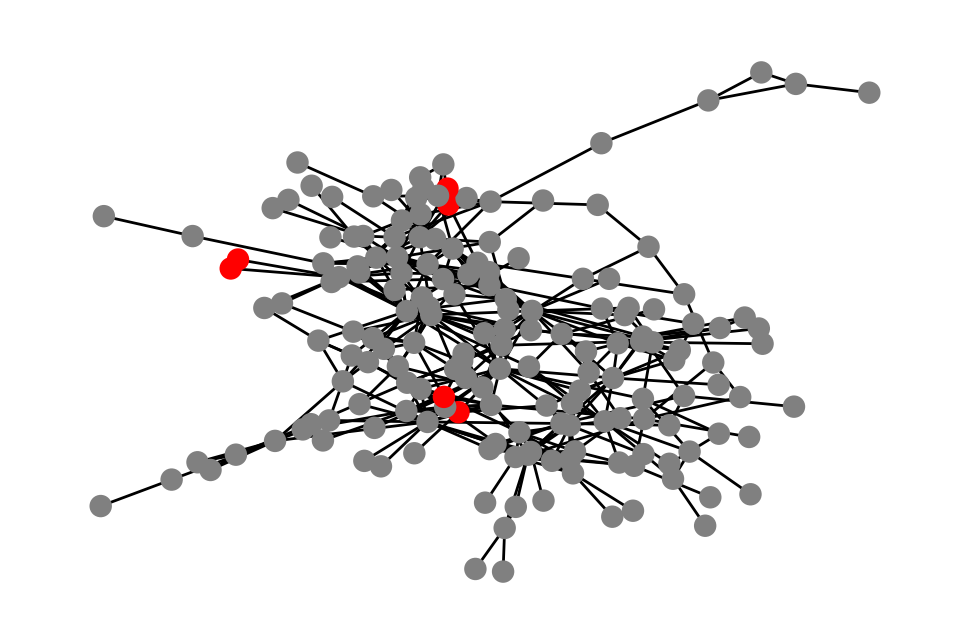

In [96]:
import matplotlib.pyplot as plt

example_cluster = subset[subset.cluster == 11250]

# Create a color mapping
color_mapping = {np.nan:'grey', 'YellowFeverVirus':'red'}

# Map the colors to the epitope annotation, YFV gets red, no annotation gets grey
annotation = example_cluster[["junction_aa", "v_call", "pathology"]]
annotation['color'] = annotation['pathology'].map(color_mapping).fillna('grey')
annotation['identifier'] = annotation['junction_aa'] + '_' + annotation['v_call']

# Next, make a dictionary of TCRs with their color
colorlabels = dict(zip(annotation.identifier, annotation.color))

# Identify which TCRs have an edit distance <= 1
edgelist = create_edgelist_vgene(example_cluster)

# Plot the graph
G = nx.from_pandas_edgelist(edgelist)

fig, ax = plt.subplots(dpi = 200)
nx.draw(G, node_color = [colorlabels[i] for i in list(G.nodes())], node_size=50, ax = ax)

fig.savefig("Graph.png", format="PNG")